**Pytorch一般有以下几个流程**


### 1.数据读取

### 2.数据处理

### 3.搭建网络

### 4.模型训练

### 5.模型上线

### 1.数据读取
CIFAR-10 是由 Hinton 的学生 Alex Krizhevsky 和 Ilya Sutskever 整理的一个用于识别普适物体的小型数据集。一共包含 10 个类别的 RGB 彩色图 片：飞机（ arplane ）、汽车（ automobile ）、鸟类（ bird ）、猫（ cat ）、鹿（ deer ）、狗（ dog ）、蛙类（ frog ）、马（ horse ）、船（ ship ）和卡车（ truck ）。图片的尺寸为 32×32 ，数据集中一共有 50000 张训练圄片和 10000 张测试图片。 

与 MNIST 数据集中目比， CIFAR-10 具有以下不同点：

    • CIFAR-10 是 3 通道的彩色 RGB 图像，而 MNIST 是灰度图像。
    • CIFAR-10 的图片尺寸为 32×32， 而 MNIST 的图片尺寸为 28×28，比 MNIST 稍大。
    • 相比于手写字符， CIFAR-10 含有的是现实世界中真实的物体，不仅噪声很大，而且物体的比例、 特征都不尽相同，这为识别带来很大困难。

首先使用`torchvision`加载和归一化我们的训练数据和测试数据。

    a、`torchvision`这个东西，实现了常用的一些深度学习的相关的图像数据的加载功能，比如cifar10、Imagenet、Mnist等等的，保存在`torchvision.datasets`模块中。
    
    b、同时，也封装了一些处理数据的方法。保存在`torchvision.transforms`模块中
    
    c、还封装了一些模型和工具封装在相应模型中,比如`torchvision.models`当中就包含了AlexNet，VGG，ResNet，SqueezeNet等模型。

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary
torch.__version__

'1.8.1+cu101'

**由于torchvision的datasets的输出是[0,1]的PILImage，所以我们先先归一化为[-1,1]的Tensor**

首先定义了一个变换transform，利用的是上面提到的transforms模块中的Compose( )把多个变换组合在一起，可以看到这里面组合了ToTensor和Normalize这两个变换

`transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`前面的（0.5，0.5，0.5） 是 R G B 三个通道上的均值， 后面(0.5, 0.5, 0.5)是三个通道的标准差，注意通道顺序是 R G B ，用过opencv的同学应该知道openCV读出来的图像是 BRG顺序。这两个tuple数据是用来对RGB 图像做归一化的，如其名称 Normalize 所示这里都取0.5只是一个近似的操作，实际上其均值和方差并不是这么多，但是就这个示例而言 影响可不计。精确值是通过分别计算R,G,B三个通道的数据算出来的。


In [2]:
transform = transforms.Compose([
#     transforms.CenterCrop(224),
    transforms.RandomCrop(32,padding=4), # 数据增广
    transforms.RandomHorizontalFlip(),  # 数据增广
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 

 `trainloader`其实是一个比较重要的东西，我们后面就是通过`trainloader`把数据传入网络，当然这里的`trainloader`其实是个变量名，可以随便取，重点是他是由后面的`torch.utils.data.DataLoader()`定义的，这个东西来源于`torch.utils.data`模块

In [3]:
Batch_Size = 256

In [4]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=8)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### 2. 查看数据（格式，大小，形状）

In [5]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [7]:
trainset.data.shape #50000是图片数量，32x32是图片大小，3是通道数量RGB

(50000, 32, 32, 3)

In [8]:
#查看数据类型
print(type(trainset.data))
print(type(trainset))

<class 'numpy.ndarray'>
<class 'torchvision.datasets.cifar.CIFAR10'>


### 总结：
    
    `trainset.data.shape`是标准的numpy.ndarray类型，其中50000是图片数量，32x32是图片大小，3是通道数量RGB；
    `trainset`是标准的？？类型，其中50000为图片数量，0表示取前面的数据，2表示3通道数RGB，32*32表示图片大小
    
 ### 3. 查看图片

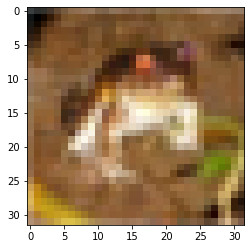

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(trainset.data[0])
im,label = iter(trainloader).next()

### np.ndarray转为torch.Tensor

在深度学习中，原始图像需要转换为深度学习框架自定义的数据格式，在pytorch中，需要转为`torch.Tensor`。
pytorch提供了`torch.Tensor` 与`numpy.ndarray`转换为接口：

方法名|作用
--|--
`torch.from_numpy(xxx)`|`numpy.ndarray`转为torch.Tensor
`tensor1.numpy()`|获取tensor1对象的numpy格式数据

`torch.Tensor` 高维矩阵的表示： N x C x H x W

`numpy.ndarray` 高维矩阵的表示：N x H x W x C

因此在两者转换的时候需要使用`numpy.transpose( )` 方法 。


In [10]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

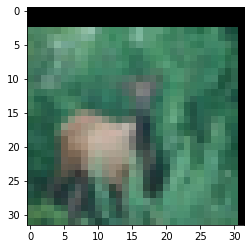

In [11]:
imshow(im[0])

In [12]:
im[0].shape

torch.Size([3, 32, 32])

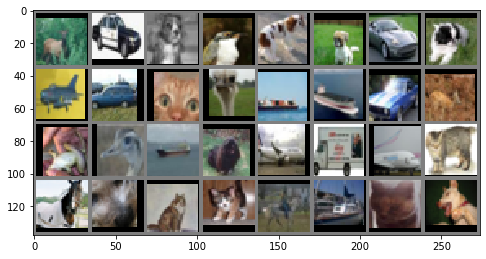

In [13]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

### 4.定义网络（GoogLeNet）

GoogLeNet在2014年由Google团队提出（与VGG网络同年，注意GoogLeNet中的L大写是为了致敬LeNet），斩获当年ImageNet竞赛中Classification Task (分类任务) 第一名。原论文名称是《Going deeper with convolutions》，下面是网络结构图。


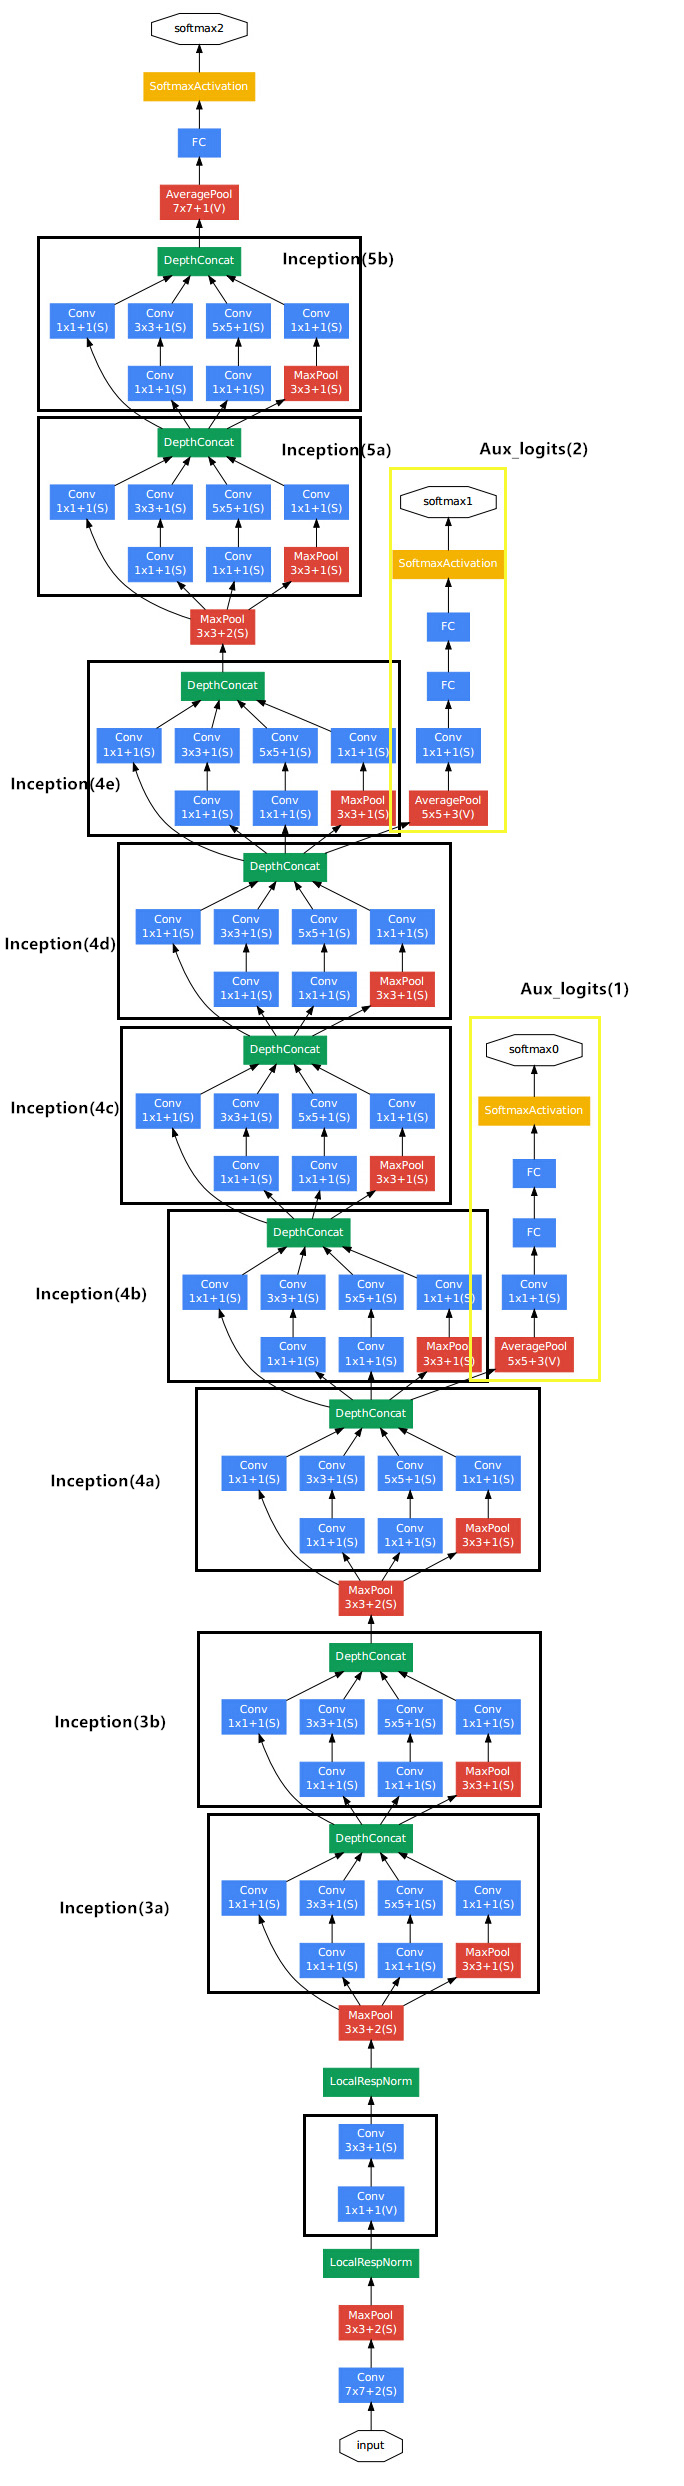


**说说该网络中的亮点：**

    （1）引入了Inception结构（融合不同尺度的特征信息）

    （2）使用1x1的卷积核进行降维以及映射处理 （虽然VGG网络中也有，但该论文介绍的更详细）

    （3）添加两个辅助分类器帮助训练

    （4）丢弃全连接层，使用平均池化层（大大减少模型参数，除去两个辅助分类器，网络大小只有vgg的1/20）


接着我们来分析一下Inception结构：

Inception v1网络是一个精心设计的22层卷积网络，并提出了具有良好局部特征结构Inception模块，即对特征并行地执行多个大小不同的卷积运算与池化，最后再拼接到一起。由于1×1、3×3和5×5的卷积运算对应不同的特征图区域，因此这样做的好处是可以得到更好的图像表征信息。为了让四个分支的输出能够在深度方向进行拼接，必须保证四个分支输出的特征矩阵高度和宽度都相同）。

Inception模块如图3.13所示，使用了三个不同大小的卷积核进行卷积运算，同时还有一个最大值池化，然后将这4部分级联起来（通道拼接），送入下一层。

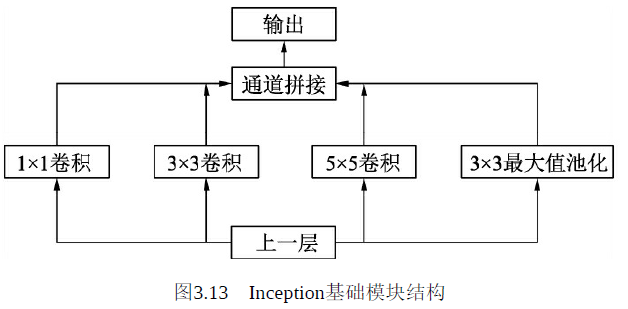

分支1是卷积核大小为1x1的卷积层，stride=1，

分支2是卷积核大小为3x3的卷积层，stride=1，padding=1（保证输出特征矩阵的高和宽和输入特征矩阵相等），

分支3是卷积核大小为5x5的卷积层，stride=1，padding=2（保证输出特征矩阵的高和宽和输入特征矩阵相等），

分支4是池化核大小为3x3的最大池化下采样，stride=1，padding=1（保证输出特征矩阵的高和宽和输入特征矩阵相等）。

在上述模块的基础上，为进一步降低网络参数量，Inception又增加了多个1×1的卷积模块。如图3.14所示，这种1×1的模块可以先将特征图降维，再送给3×3和5×5大小的卷积核，由于通道数的降低，参数量也有了较大的减少。

Inception v1网络一共有9个上述堆叠的模块，共有22层，在最后的Inception模块处使用了全局平均池化。

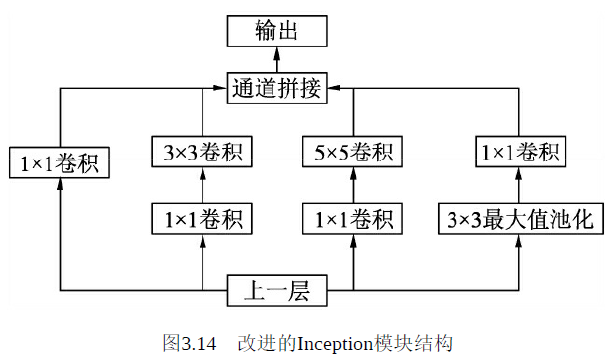

为了避免深层网络训练时带来的梯度消失问题，作者还引入了两个辅助的分类器，在第3个与第6个Inception模块输出后执行Softmax并计算损失，在训练时和最后的损失一并回传。
接着下来在看看辅助分类器结构，网络中的两个辅助分类器结构是一模一样的，如下图所示：

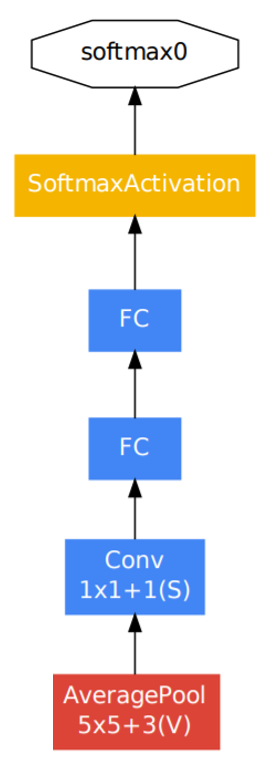
辅助分类器：

    第一层是一个平均池化下采样层，池化核大小为5x5，stride=3

    第二层是卷积层，卷积核大小为1x1，stride=1，卷积核个数是128

    第三层是全连接层，节点个数是1024

    第四层是全连接层，节点个数是1000（对应分类的类别个数）
    
    
Inception v1的参数量是AlexNet的1/12，VGGNet的1/3，适合处理大规模数据，尤其是对于计算资源有限的平台。

**Inception v2**

在Inception v1网络的基础上，随后又出现了多个Inception版本。Inception v2进一步通过卷积分解与正则化实现更高效的计算，增加了BN层，同时利用两个级联的3×3卷积取代Inception v1版本中的5×5卷积，如图3.15所示，这种方式既减少了卷积参数量，也增加了网络的非线性能力。

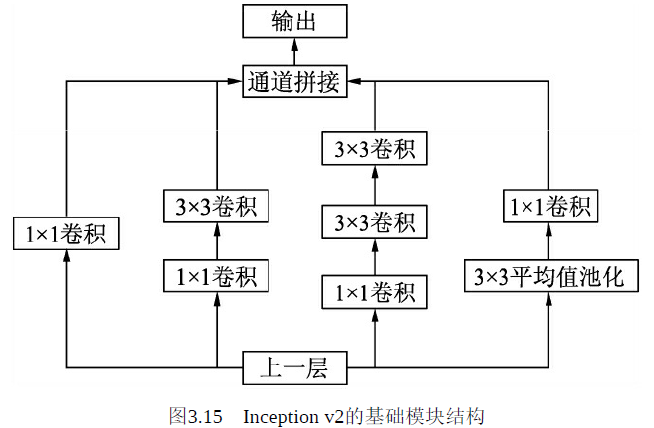


此外除了这两个版本，这几年还分别出了Inception v3和Inception v4。

Inception v3在Inception v2的基础上，使用了RMSProp优化器，在辅助的分类器部分增加了7×7的卷积，并且使用了标签平滑技术。


Inception v4则是将Inception的思想与残差网络进行了结合，显著提升了训练速度与模型准确率，这里对于模块细节不再展开讲述。至于残差网络这一里程碑式的结构，正是由下一节的网络ResNet引出的。


**这里演示只展示一个Inception v1的网络结构**有兴趣的话也可以尝试其他网络结构

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
# 定义一个卷积加一个 relu 激活函数和一个 batchnorm 作为一个基本的层结构
class BasicConv2d(nn.Module):
    def __init__(self,in_channel, out_channel, kernel_size, stride=1, padding=0):
        super(BasicConv2d,self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding)
        self.batch = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU(True)
    def forward(self, x):
        x = self.conv(x)
        x = self.batch(x)
        x = self.relu(x)
        return x

In [16]:
class Inception(nn.Module):
    def __init__(self, in_channel, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_proj):
        super(Inception, self).__init__()
        
        # 第一条线路
        self.branch1x1 = BasicConv2d(in_channel, n1x1, 1)
        
        # 第二条线路
        self.branch3x3 = nn.Sequential( 
            BasicConv2d(in_channel, n3x3red, 1),
            BasicConv2d(n3x3red, n3x3, 3, padding=1)
        )
        
        # 第三条线路
        self.branch5x5 = nn.Sequential(
            BasicConv2d(in_channel, n5x5red, 1),
            BasicConv2d(n5x5red, n5x5, 5, padding=2)
        )
        
        # 第四条线路
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size= 3, stride=1, padding=1),
            BasicConv2d(in_channel, pool_proj, 1)
        )
    def forward(self, x):
        f1 = self.branch1x1(x)
        f2 = self.branch3x3(x)
        f3 = self.branch5x5(x)
        f4 = self.branch_pool(x)
        output = torch.cat((f1, f2, f3, f4), dim=1)
        return output

In [17]:
class InceptionAux(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(InceptionAux, self).__init__()
#         self.averagePool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.averagePool = nn.AvgPool2d(kernel_size=2)
        self.conv = BasicConv2d(in_channel, 128, kernel_size=1)  # output[batch, 128, 4, 4]
        
        self.fc1 = nn.Sequential(
#             nn.Linear(2048, 1024),
            nn.Linear(128,64),
            nn.ReLU(True)
        )
#         self.drop = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(1024, num_classes)
        self.fc2 = nn.Linear(64, num_classes)
    def forward(self, x):

        x = self.averagePool(x)
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = F.dropout(x, 0.5, training=self.training)
        x = self.fc1(x)
        x = F.dropout(x, 0.5, training=self.training)
        x = self.fc2(x)
        return x

In [18]:
test_net = Inception(3, 64, 48, 64, 64, 96, 32)
test_x =torch.zeros(1, 3, 32, 32)
print('input shape: {} x {} x {}'.format(test_x.shape[1], test_x.shape[2], test_x.shape[3]))
test_y = test_net(test_x)
print('output shape: {} x {} x {}'.format(test_y.shape[1], test_y.shape[2], test_y.shape[3]))

input shape: 3 x 32 x 32
output shape: 256 x 32 x 32


In [19]:
class GoogLeNet(nn.Module):
    def __init__(self, in_channel, num_classes, aux_logits=False, verbose=False, init_weights=True):
        super(GoogLeNet, self).__init__()
        self.verbose = verbose
        self.aux_logits = aux_logits
        
#         self.block1 = nn.Sequential(
#             BasicConv2d(in_channel, out_channel=64, kernel=7, stride=2, padding=3),
#             nn.MaxPool2d(3, 2, ceil_mode=True)
#         )
        
#         self.block2 = nn.Sequential(
#             BasicConv2d(64, 64, kernel=1),
#             BasicConv2d(64, 192, kernel=3, padding=1),
#             nn.MaxPool2d(3, 2, ceil_mode=True)
#         )
        
#         self.block3 = nn.Sequential(
#             inception(192, 64, 96, 128, 16, 32, 32),
#             inception(256, 128, 128, 192, 32, 96, 64),
#             nn.MaxPool2d(3, 2, ceil_mode=True)
#         )
        
#         self.block4 = nn.Sequential(
#             inception(480, 192, 96, 208, 16, 48, 64),
#             inception(512, 160, 112, 224, 24, 64, 64),
#             inception(512, 128, 128, 256, 24, 64, 64),
#             inception(512, 112, 144, 288, 32, 64, 64),
#             inception(528, 256, 160, 320, 32, 128, 128),
#             nn.MaxPool2d(3, 2, ceil_mode=True)
#         )
        
#         self.block5 = nn.Sequential(
#             inception(832, 256, 160, 320, 32, 128, 128),
#             inception(832, 384, 182, 384, 48, 128, 128),
            
#         )
        # block1
        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        # block2
        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        # block3
        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        # block4
        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        # block5
        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)
        
        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)
        
#         self.avgpool = nn.AvgPool2d(7)
        self.avgpool = nn.AvgPool2d(1) # 对32x32 不一样
        self.dropout = nn.Dropout(0.4)
        self.classifier = nn.Linear(1024, num_classes)
        if init_weights:
            self._initialize_weights()
        
            
    def forward(self, x):
#         x = self.block1(x)
        x = self.conv1(x)
        x = self.maxpool1(x)
        if self.verbose:
            print('block 1 output: {}'.format(x.shape))
#         x = self.block2(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)
        if self.verbose:
            print('block 2 output: {}'.format(x.shape))
#         x = self.block3(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        if self.verbose:
            print('block 3 output: {}'.format(x.shape))
#         x = self.block4(x)
        x = self.inception4a(x)
        if self.training and self.aux_logits:    # eval model lose this layer
            aux1 = self.aux1(x)
            if self.verbose:
                print('aux 1 output: {}'.format(aux1.shape))
            
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.training and self.aux_logits:    # eval model lose this layer
            aux2 = self.aux2(x)
            if self.verbose:
                print('aux 2 output: {}'.format(aux2.shape))
        x = self.inception4e(x)
        x = self.maxpool4(x)
        if self.verbose:
            print('block 4 output: {}'.format(x.shape))
#         x = self.block5(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        if self.verbose:
            print('block 5 output: {}'.format(x.shape))
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        x = self.classifier(x)
        if self.training and self.aux_logits:   # eval model lose this layer
            return x, aux2, aux1
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [20]:
net = GoogLeNet(3,10,aux_logits = True, verbose = False).to(device)

In [21]:
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,472
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
       BasicConv2d-4           [-1, 64, 16, 16]               0
         MaxPool2d-5             [-1, 64, 8, 8]               0
            Conv2d-6             [-1, 64, 8, 8]           4,160
       BatchNorm2d-7             [-1, 64, 8, 8]             128
              ReLU-8             [-1, 64, 8, 8]               0
       BasicConv2d-9             [-1, 64, 8, 8]               0
           Conv2d-10            [-1, 192, 8, 8]         110,784
      BatchNorm2d-11            [-1, 192, 8, 8]             384
             ReLU-12            [-1, 192, 8, 8]               0
      BasicConv2d-13            [-1, 192, 8, 8]               0
        MaxPool2d-14            [-1, 19

In [22]:
print(net)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (batch): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (batch): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1x1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch): 

In [23]:
test_net = GoogLeNet(3, 10, aux_logits = True,verbose = True)
test_x = torch.zeros(3, 3, 32, 32)
test_net.train
test_y = test_net(test_x)
print('output: {}'.format(test_y[0].shape))

block 1 output: torch.Size([3, 64, 8, 8])
block 2 output: torch.Size([3, 192, 4, 4])
block 3 output: torch.Size([3, 480, 2, 2])
aux 1 output: torch.Size([3, 10])
aux 2 output: torch.Size([3, 10])
block 4 output: torch.Size([3, 832, 1, 1])
block 5 output: torch.Size([3, 1024, 1, 1])
output: torch.Size([3, 10])


In [24]:
net = GoogLeNet(3,10,aux_logits=True).to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True

### 5. 定义损失函数和优化器 
    pytorch将深度学习中常用的优化方法全部封装在torch.optim之中，所有的优化方法都是继承基类optim.Optimizier
    
    损失函数是封装在神经网络工具箱nn中的,包含很多损失函数


In [25]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5 ,patience = 5,min_lr = 0.000001) # 动态更新学习率
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 150], gamma=0.5)
import time
epoch = 20

### 6. 训练


不出意外的话，会报错，因为在这22层的结构当中输入图片大小为32x32，但是在中间计算的一系列过程中，32x32的图片大小在某个环节就会出现计算结果0x0的大小，所以不匹配。
但是为了和论文相同，我这里在数据的transform中，就全部改成3x224x224了，所以就不会报错。
如果想用3x32x32，我们可能需要对我们的平均池化层进行修改
我这里用的是32x32x3

In [26]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('文件已存在')
save_path = './model/GoogLeNet.pth'

文件已存在


In [27]:
import time
best_acc = 0
train_acc_list, test_acc_list = [],[]
train_loss_list, test_loss_list = [],[]
lr_list  = []
for i in range(epoch):
    start = time.time()
    train_loss = 0
    train_acc = 0
    test_loss = 0
    test_acc = 0
    if torch.cuda.is_available():
        net = net.to(device)
    net.train()
    for step,data in enumerate(trainloader,start=0):
        im,label = data
        im = im.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        logits, aux_logits2, aux_logits1 = net(im)
        loss0 = criterion(logits, label)
        loss1 = criterion(aux_logits1, label)
        loss2 = criterion(aux_logits2, label)
        loss = loss0 + loss1 * 0.3 + loss2 * 0.3
        loss.backward()
        optimizer.step()
        outputs = logits
        train_loss += loss.data
        probs, pred_y = outputs.data.max(dim=1) # 得到概率
        train_acc += (pred_y==label).sum()/label.size(0)

        rate = (step + 1) / len(trainloader)
        a = "*" * int(rate * 50)
        b = "." * (50 - int(rate * 50))
        print('\r train {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,epoch,int(rate*100),a,b),end='')

    train_loss = train_loss / len(trainloader)
    train_acc = train_acc * 100 / len(trainloader)
#     print('train_loss:{:.3f} train_acc:{:3.2f}%' .format(train_loss ,train_acc),end=' ')  
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    lr = optimizer.param_groups[0]['lr']
    lr_list.append(lr)
    scheduler.step(train_loss)
    
    net.eval()
    with torch.no_grad():
        for step,data in enumerate(testloader,start=0):
            im,label = data
            im = im.to(device)
            label = label.to(device)
            outputs = net(im)
            loss = criterion(outputs,label)
            test_loss += loss.data
            probs, pred_y = outputs.data.max(dim=1) # 得到概率
            test_acc += (pred_y==label).sum()/label.size(0)
            rate = (step + 1) / len(testloader)
            a = "*" * int(rate * 50)
            b = "." * (50 - int(rate * 50))
            print('\r test  {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,epoch,int(rate*100),a,b),end='')
    test_loss = test_loss / len(testloader)
    test_acc = test_acc * 100 /len(testloader)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    end = time.time()
    print('\rEpoch [{:>3d}/{:>3d}]  Train Loss:{:>.6f}  Train Acc:{:>3.2f}% Test Loss:{:>.6f}  Test Acc:{:>3.2f}%  Learning Rate:{:>.6f}'.format(
                    i + 1, epoch, train_loss, train_acc, test_loss, test_acc,lr), end='')
    time_ = int(end - start)
    time_ = int(end - start)
    h = time_ / 3600
    m = time_ % 3600 /60
    s = time_ % 60
    time_str = "\tTime %02d:%02d" % ( m, s)
    # 打印所用时间
    print(time_str)
    # 如果取得更好的准确率，就保存模型
    if test_acc > best_acc:
        torch.save(net,save_path)
        best_acc = test_acc

Acc = {}
Loss = {}
Acc['train_acc'] = train_acc_list
Acc['test_acc'] = test_acc_list
Loss['train_loss'] = train_loss_list
Loss['test_loss'] = test_loss_list
Lr = lr_list

Epoch [  1/ 20]  Train Loss:3.502581  Train Acc:28.39% Test Loss:1.754732  Test Acc:32.62%  Learning Rate:0.100000	Time 01:18
Epoch [  2/ 20]  Train Loss:3.025650  Train Acc:34.54% Test Loss:1.594922  Test Acc:40.62%  Learning Rate:0.100000	Time 00:47
Epoch [  3/ 20]  Train Loss:2.479797  Train Acc:45.04% Test Loss:1.376943  Test Acc:49.98%  Learning Rate:0.100000	Time 00:47
Epoch [  4/ 20]  Train Loss:2.187865  Train Acc:51.80% Test Loss:1.343571  Test Acc:52.06%  Learning Rate:0.100000	Time 00:48
Epoch [  5/ 20]  Train Loss:1.946148  Train Acc:58.07% Test Loss:1.442292  Test Acc:50.00%  Learning Rate:0.100000	Time 00:49
Epoch [  6/ 20]  Train Loss:1.786479  Train Acc:61.72% Test Loss:1.102130  Test Acc:60.99%  Learning Rate:0.100000	Time 00:50
Epoch [  7/ 20]  Train Loss:1.898810  Train Acc:58.88% Test Loss:1.195833  Test Acc:57.88%  Learning Rate:0.100000	Time 00:48
Epoch [  8/ 20]  Train Loss:1.664467  Train Acc:64.54% Test Loss:1.034277  Test Acc:63.97%  Learning Rate:0.100000	Tim

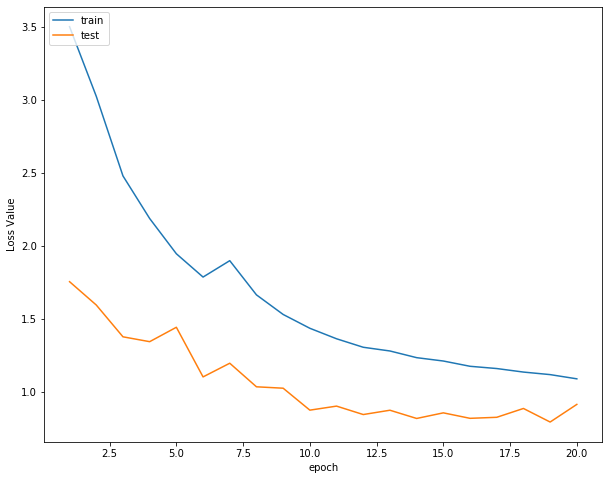

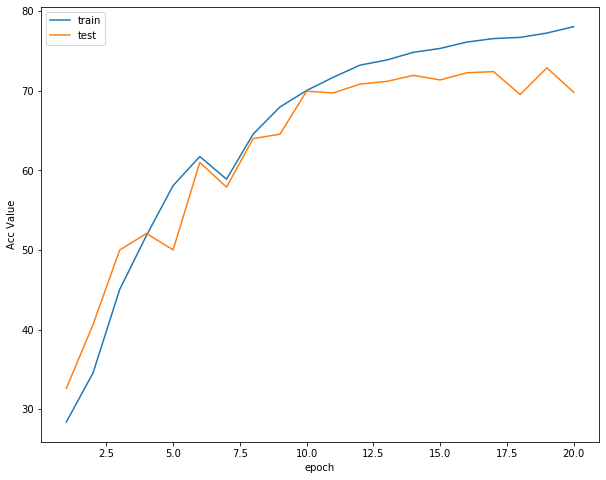

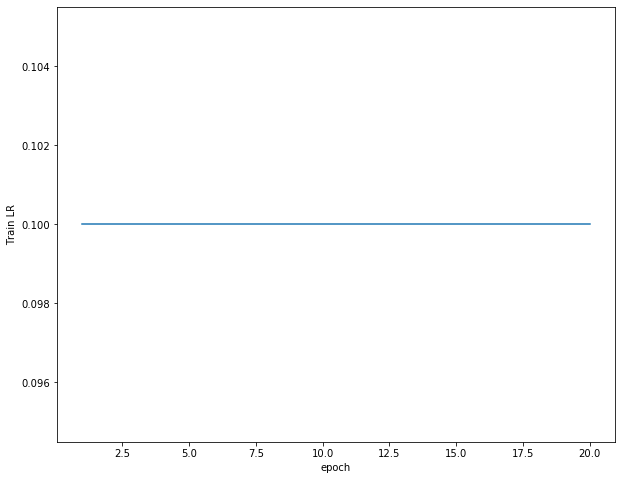

In [28]:
from utils import plot_history
plot_history(epoch, Acc, Loss, Lr)

### 7.测试

In [29]:
correct = 0   # 定义预测正确的图片数，初始化为0
total = 0     # 总共参与测试的图片数，也初始化为0
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:  # 循环每一个batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        net.eval()  # 把模型转为test模式
        if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
        outputs = net(images)  # 输入网络进行测试

        # outputs.data是一个4x10张量，将每一行的最大的那一列的值和序号各自组成一个一维张量返回，第一个是值的张量，第二个是序号的张量。
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)          # 更新测试图片的数量
        correct += (predicted == labels).sum() # 更新正确分类的图片的数量

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))
 

Accuracy of the network on the 10000 test images: 69.88 %


In [30]:
 # 定义2个存储每类中测试正确的个数的 列表，初始化为0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
    #4组(batch_size)数据中，输出于label相同的，标记为1，否则为0
        c = (predicted == labels).squeeze()
        for i in range(len(images)):      # 因为每个batch都有4张图片，所以还需要一个4的小循环
            label = labels[i]   # 对各个类的进行各自累加
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 86.70 %
Accuracy of automobile : 93.80 %
Accuracy of  bird : 56.10 %
Accuracy of   cat : 49.50 %
Accuracy of  deer : 79.30 %
Accuracy of   dog : 61.20 %
Accuracy of  frog : 86.50 %
Accuracy of horse : 54.90 %
Accuracy of  ship : 84.60 %
Accuracy of truck : 48.30 %


Accuracy Rate = 69.140625%


<Figure size 1800x288 with 0 Axes>

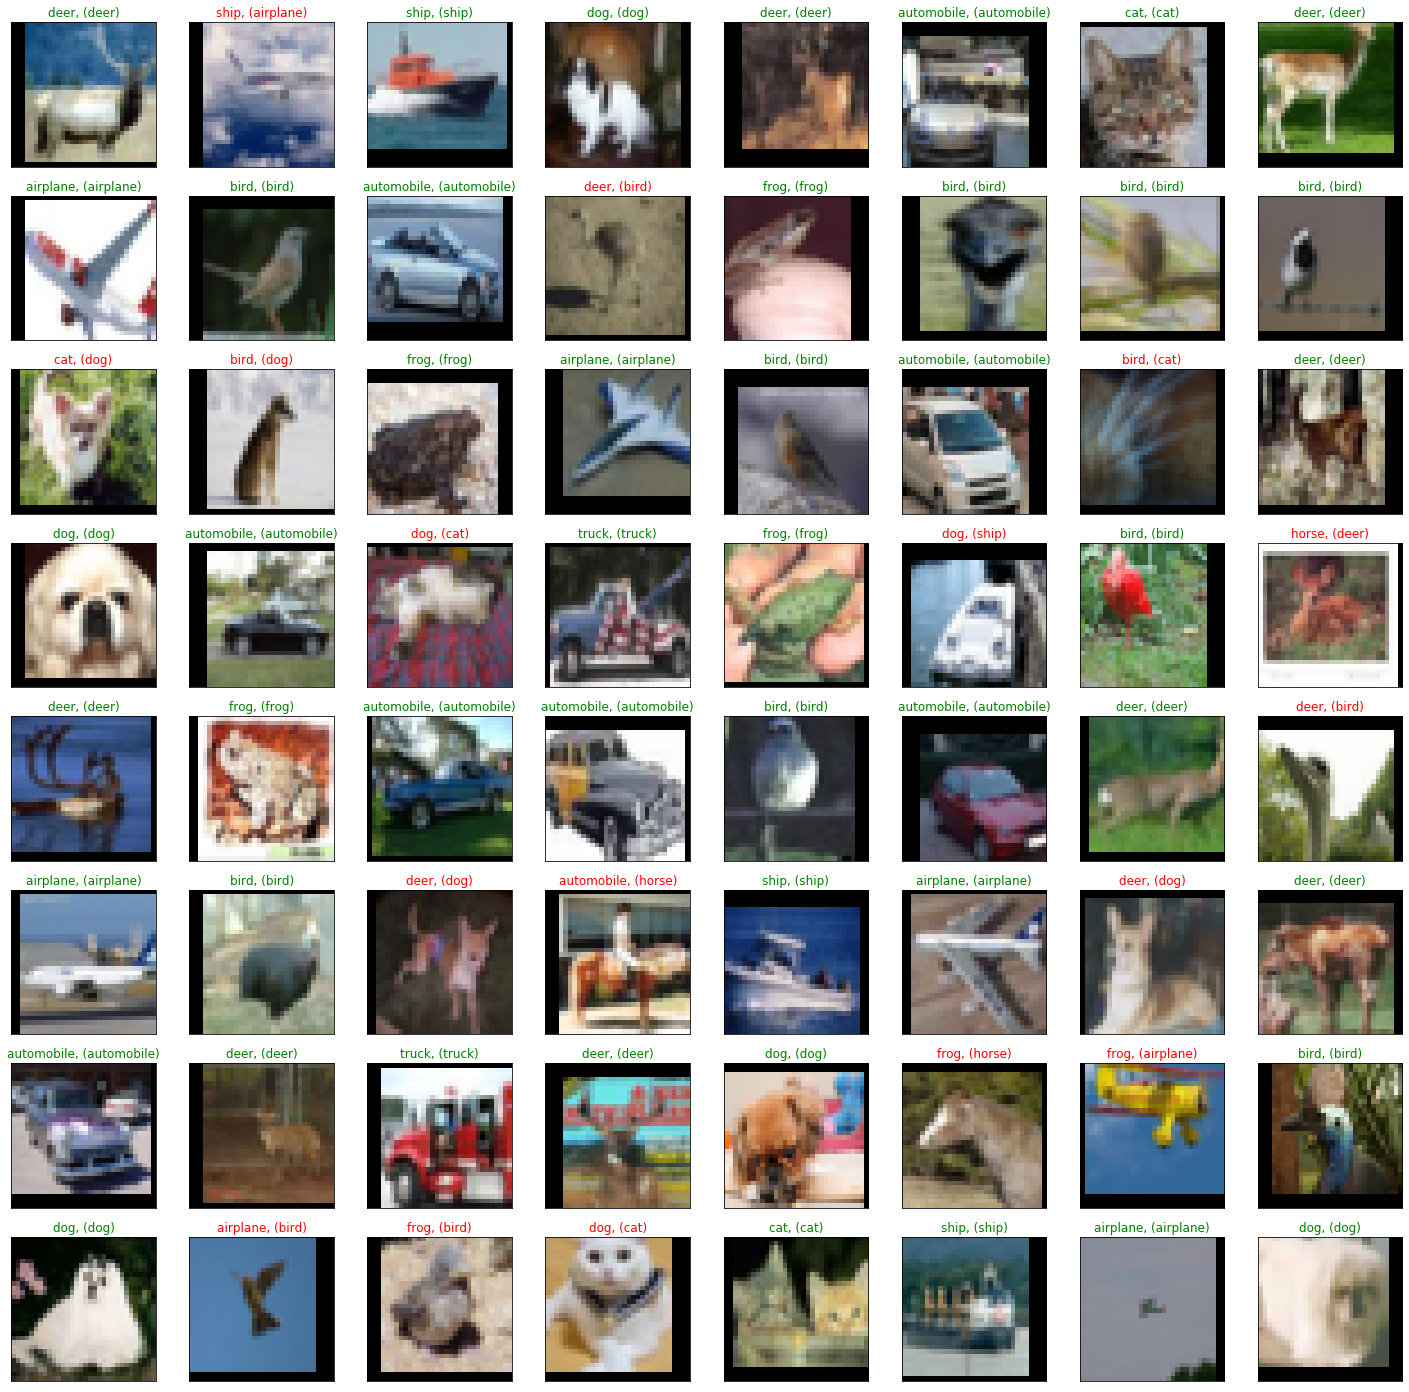

In [31]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(64):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    #fig.tight_layout()
#     plt.imshow(im_convert(images[idx]))
    imshow(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

### 8. 保存模型

In [32]:
torch.save(net,save_path[:-4]+str(epoch)+'.pth')
# torch.save(net, './model/GoogLeNet-256.pth')

### 9. 预测

In [33]:
import torch
from PIL import Image
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GoogLeNet(3,num_classes=10, aux_logits=True)

model = torch.load(save_path)  # 加载模型
# model = model.to('cuda')
model.eval()  # 把模型转为test模式

# 读取要预测的图片
img = Image.open("./airplane.jpg").convert('RGB') # 读取图像

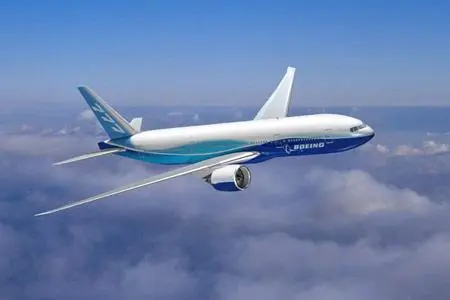

In [34]:
img

In [35]:
trans = transforms.Compose([transforms.Scale((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

c:\users\86137\appdata\local\programs\python\python37\lib\site-packages\torchvision\transforms\transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


概率 tensor([[9.9385e-01, 1.7306e-04, 7.7972e-04, 5.7594e-05, 9.7720e-05, 1.8072e-05,
         2.5149e-05, 4.5894e-05, 4.7694e-03, 1.8658e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
类别 0
tensor([8.0125], device='cuda:0')
分类 plane


<Response [200]>


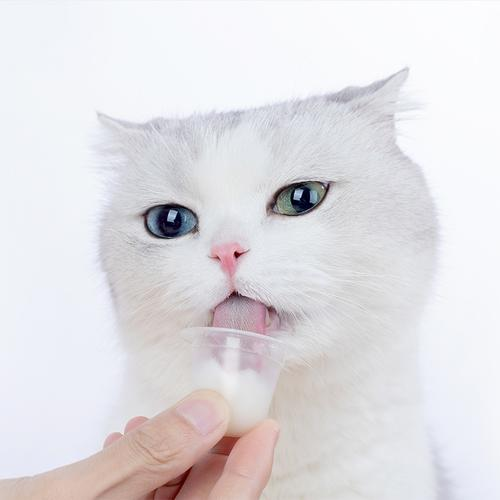

In [36]:
import requests
from PIL import Image
url = 'https://dss2.bdstatic.com/70cFvnSh_Q1YnxGkpoWK1HF6hhy/it/u=947072664,3925280208&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFuHSh_Q1YnxGkpoWK1HF6hhy/it/u=2952045457,215279295&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=2838383012,1815030248&fm=26&gp=0.jpg'
url = 'https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fwww.goupuzi.com%2Fnewatt%2FMon_1809%2F1_179223_7463b117c8a2c76.jpg&refer=http%3A%2F%2Fwww.goupuzi.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1624346733&t=36ba18326a1e010737f530976201326d'
url = 'https://ss3.bdstatic.com/70cFv8Sh_Q1YnxGkpoWK1HF6hhy/it/u=2799543344,3604342295&fm=224&gp=0.jpg'
# url = 'https://ss1.bdstatic.com/70cFuXSh_Q1YnxGkpoWK1HF6hhy/it/u=2032505694,2851387785&fm=26&gp=0.jpg'
response = requests.get(url, stream=True)
print (response)
img = Image.open(response.raw)
img

In [37]:
trans = transforms.Compose([transforms.Scale((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

概率 tensor([[0.7752, 0.0063, 0.0506, 0.0376, 0.0050, 0.0109, 0.0094, 0.0070, 0.0901,
         0.0080]], device='cuda:0', grad_fn=<SoftmaxBackward>)
类别 0
tensor([3.5706], device='cuda:0')
分类 plane


c:\users\86137\appdata\local\programs\python\python37\lib\site-packages\torchvision\transforms\transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


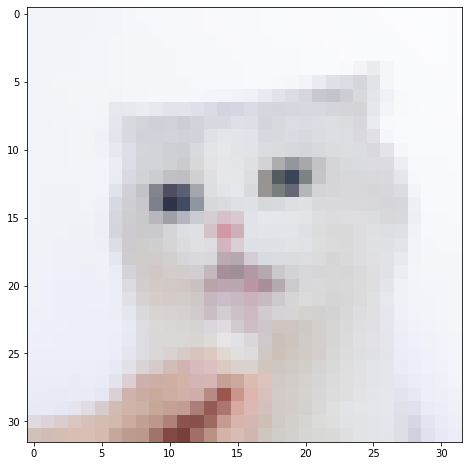

In [48]:
imshow(img.cpu().squeeze())